In [1]:
# Importing all the necessary files
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from scipy.stats import entropy
import geopandas as gpd
import os
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
# Files Loading
all_csv_files = glob.glob("7796666/*.csv") # Reference [1]
csv_df_list = []
for file in all_csv_files:
    csv_df = pd.read_csv(file)
    file_name = os.path.basename(file)
    month_abbr = file_name[:3]
    # Adding months in a new column to files which have monthly data
    if not file_name.startswith('year'):
        csv_df['month'] = month_abbr  
        csv_df_list.append(csv_df)
grocery_df = pd.concat(csv_df_list, ignore_index=True)
grocery_df.head()

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,month
0,E05000026,426.121318,35.0,154.0,300.0,500.0,1500.0,662.588047,10.999740,117.272418,...,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905,Jul
1,E05000027,396.478979,32.5,150.0,300.0,454.0,1200.0,548.424075,16.052851,112.303223,...,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706,Jul
2,E05000028,384.863425,32.5,150.0,300.0,471.0,1200.0,470.716806,8.285225,113.598482,...,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271,Jul
3,E05000029,355.135134,30.0,140.0,250.0,420.0,1200.0,487.818299,14.820986,120.008922,...,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172,Jul
4,E05000030,339.507600,30.0,140.0,250.0,415.0,1000.0,384.675705,11.160665,114.485619,...,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362,Jul


Insight 1

In [3]:
# Gathering MSOA data
insight_1 = pd.DataFrame(grocery_df)
insight_1['area_id'] = insight_1['area_id'].astype(str)
filtered_df = insight_1[(insight_1['area_id'] >= 'E02000001') & (insight_1['area_id'] <= 'E02006931') & (insight_1['month'].notnull())]

In [4]:
# Mapping monthly data for proper order
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
filtered_df['month_num'] = filtered_df['month'].map(month_mapping)

# Taking fresh food and convenient food columns
fresh_foods_cols = ['f_dairy', 'f_eggs', 'f_fish', 'f_fruit_veg', 'f_grains', 'f_meat_red', 'f_poultry']
convenience_foods_cols = ['f_fats_oils', 'f_readymade', 'f_sauces', 'f_sweets']

# Setup for plotting
filtered_df['total_fresh'] = filtered_df[fresh_foods_cols].sum(axis=1)
filtered_df['total_convenience'] = filtered_df[convenience_foods_cols].sum(axis=1)
agg_data = filtered_df.groupby('month_num').agg({'total_fresh': 'sum', 'total_convenience': 'sum'}).reset_index()
gdf = gpd.read_file('statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp') # Use shp file to get London MSOA map, Reference[2]
agg_data_fresh = filtered_df.groupby('area_id')['total_fresh'].mean().reset_index()
gdf_merged = gdf.merge(agg_data_fresh, left_on='MSOA11CD', right_on='area_id', how='left')

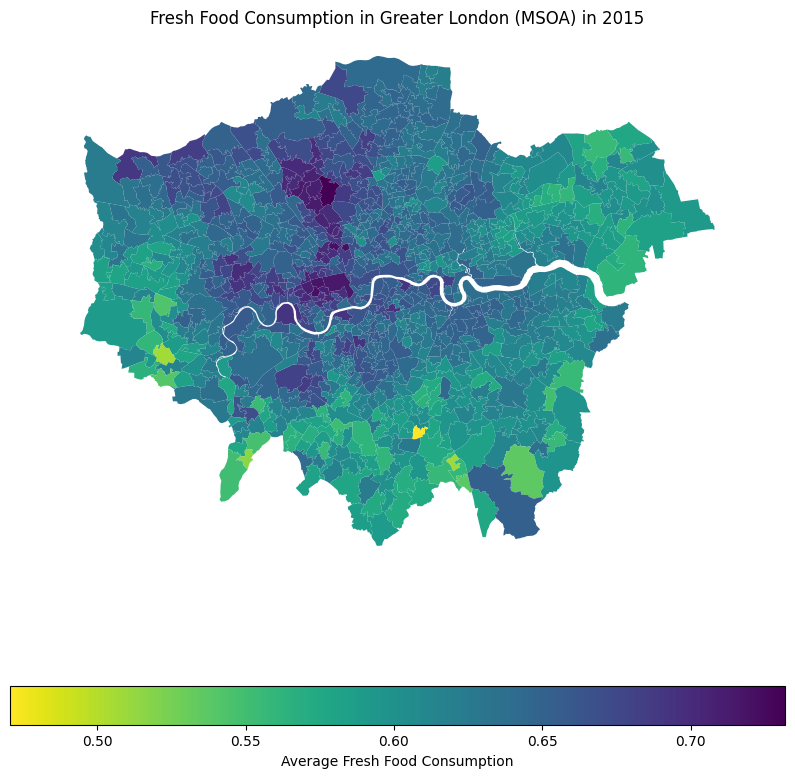

In [5]:
# Plotting of Fresh food consumption
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.axis('off')
gdf_merged.plot(column='total_fresh', ax=ax, legend=True,cmap='viridis_r',
                legend_kwds={'label': "Average Fresh Food Consumption",
                             'orientation': "horizontal"})
plt.title('Fresh Food Consumption in Greater London (MSOA) in 2015')
plt.show()

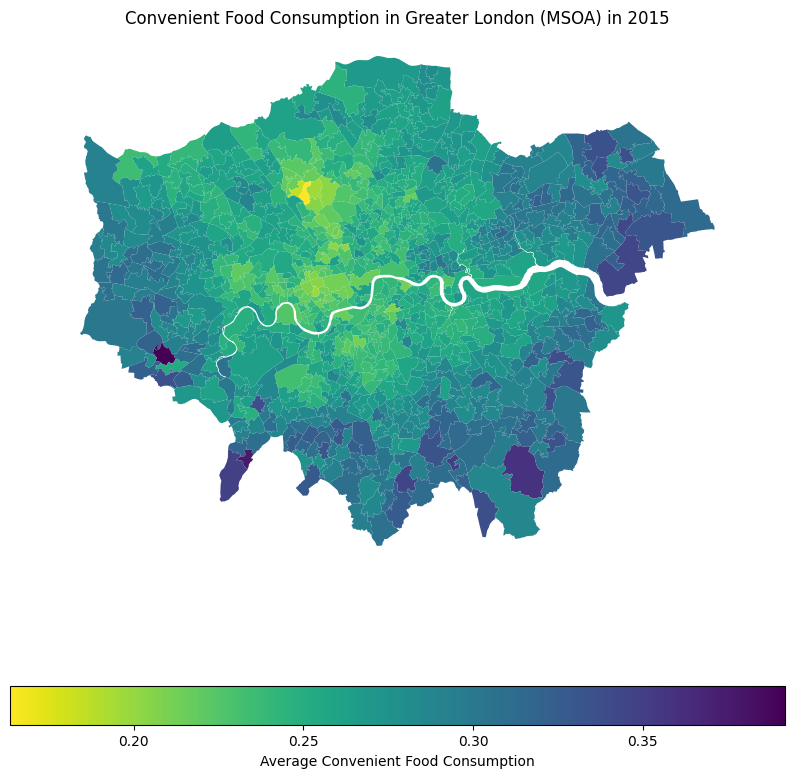

In [6]:
# Plotting for Convenient Food Consumption
agg_data_convenience = filtered_df.groupby('area_id')['total_convenience'].mean().reset_index()
gdf_merged = gdf.merge(agg_data_convenience, left_on='MSOA11CD', right_on='area_id', how='left')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.axis('off')
gdf_merged.plot(column='total_convenience', ax=ax, legend=True,cmap='viridis_r',
                legend_kwds={'label': "Average Convenient Food Consumption",
                             'orientation': "horizontal"})
plt.title('Convenient Food Consumption in Greater London (MSOA) in 2015')
plt.show()

<Figure size 1400x800 with 0 Axes>

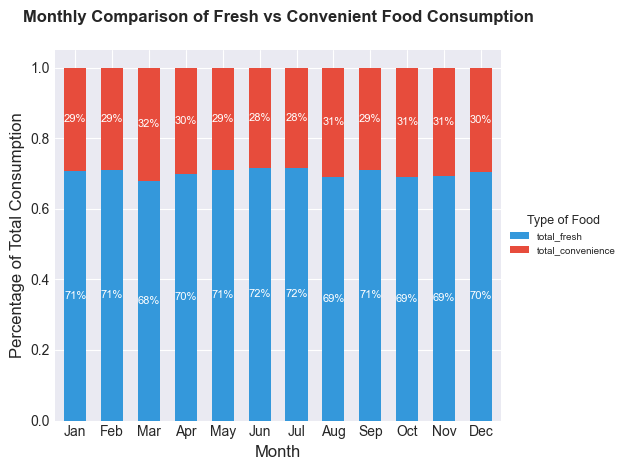

In [7]:
# Monthly Comparison of Fresh vs Convenient Food Consumption
months_ordered = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_totals = filtered_df.groupby('month')[['total_fresh', 'total_convenience']].sum().reset_index()
monthly_totals.set_index('month', inplace=True)
monthly_totals.sort_values('month', inplace=True)

# Plotting:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(14, 8))
monthly_totals_perc = monthly_totals.apply(lambda x: x / x.sum(), axis=1)

ax = monthly_totals_perc.plot(kind='bar', stacked=True, color=['#3498db', '#e74c3c'],width=0.6)
ax.set_title('Monthly Comparison of Fresh vs Convenient Food Consumption', fontsize=12, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Percentage of Total Consumption', fontsize=12)
ax.tick_params(axis='x', labelrotation=0, labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.legend(title='Type of Food', fontsize=7, title_fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5))

for i, (fresh, processed) in enumerate(zip(monthly_totals_perc['total_fresh'], monthly_totals_perc['total_convenience'])):
    ax.text(i, fresh / 2, f'{fresh:.0%}', ha='center', va='center', color='white', fontsize=8)
    ax.text(i, fresh + processed / 2, f'{processed:.0%}', ha='center', va='center', color='white', fontsize=8)
plt.setp(ax,xticklabels=months_ordered)
plt.tight_layout()
plt.show()

Insight 2

In [8]:
new_df=pd.read_csv("7796666/year_borough_grocery.csv") #Reference[1]

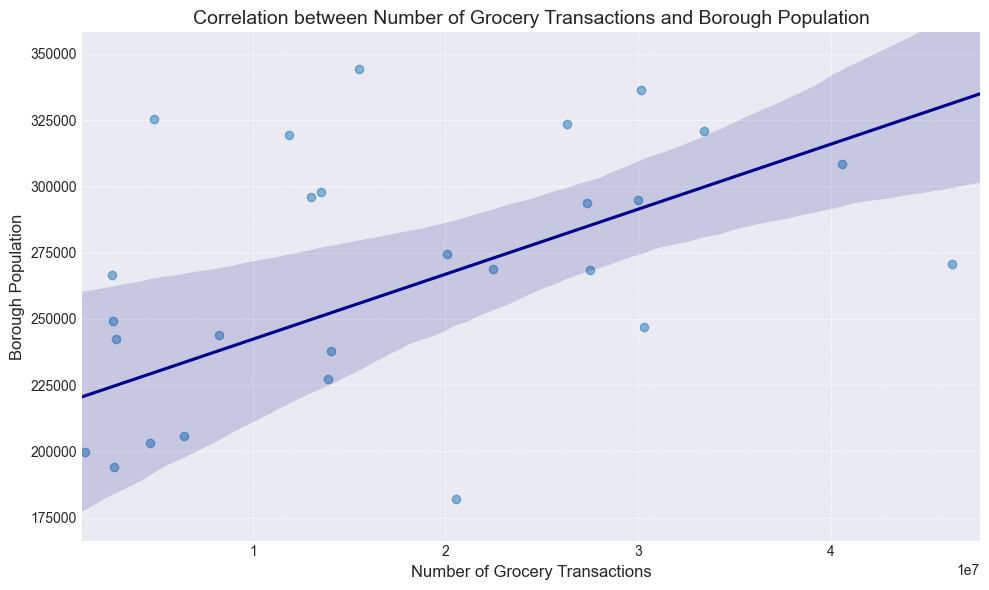

In [9]:
#Calculating and Plotting Correlation between Number of Grocery Transactions and Borough Population
plt.figure(figsize=(10, 6))
sns.regplot(data=new_df,x='num_transactions',y='population',scatter_kws={'alpha': 0.5},line_kws={'color': 'darkblue'})
correlation_1 = new_df['num_transactions'].corr(new_df['population'])

plt.title('Correlation between Number of Grocery Transactions and Borough Population', fontsize=14)
plt.xlabel('Number of Grocery Transactions', fontsize=12)
plt.ylabel('Borough Population', fontsize=12)
xlim_low = new_df['num_transactions'].quantile(0.05)
xlim_high = new_df['num_transactions'].quantile(0.95)
ylim_low = new_df['population'].quantile(0.05)
ylim_high = new_df['population'].quantile(0.95)

plt.xlim(xlim_low, xlim_high)
plt.ylim(ylim_low, ylim_high)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

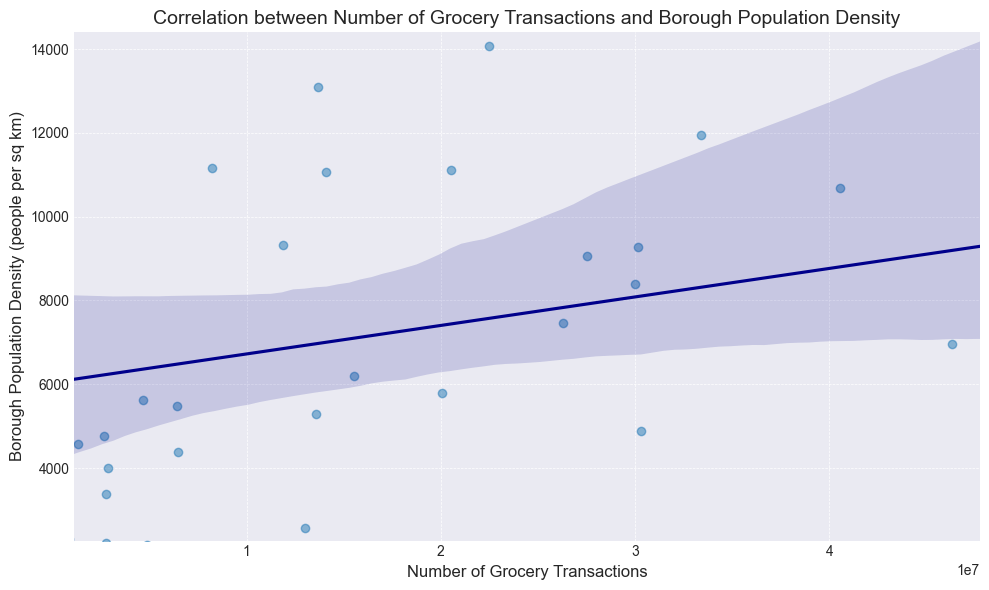

In [10]:
#Calculating and Plotting Correlation between Number of Grocery Transactions and Borough Population Density
plt.figure(figsize=(10, 6))
sns.regplot(data=new_df,x='num_transactions',y='people_per_sq_km',scatter_kws={'alpha': 0.5},line_kws={'color': 'darkblue'})
correlation = new_df['num_transactions'].corr(new_df['people_per_sq_km'])

plt.title('Correlation between Number of Grocery Transactions and Borough Population Density', fontsize=14)
plt.xlabel('Number of Grocery Transactions', fontsize=12)
plt.ylabel('Borough Population Density (people per sq km)', fontsize=12)
xlim_low = new_df['num_transactions'].quantile(0.05)
xlim_high = new_df['num_transactions'].quantile(0.95)
ylim_low = new_df['people_per_sq_km'].quantile(0.05)
ylim_high = new_df['people_per_sq_km'].quantile(0.95)

plt.xlim(xlim_low, xlim_high)
plt.ylim(ylim_low, ylim_high)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


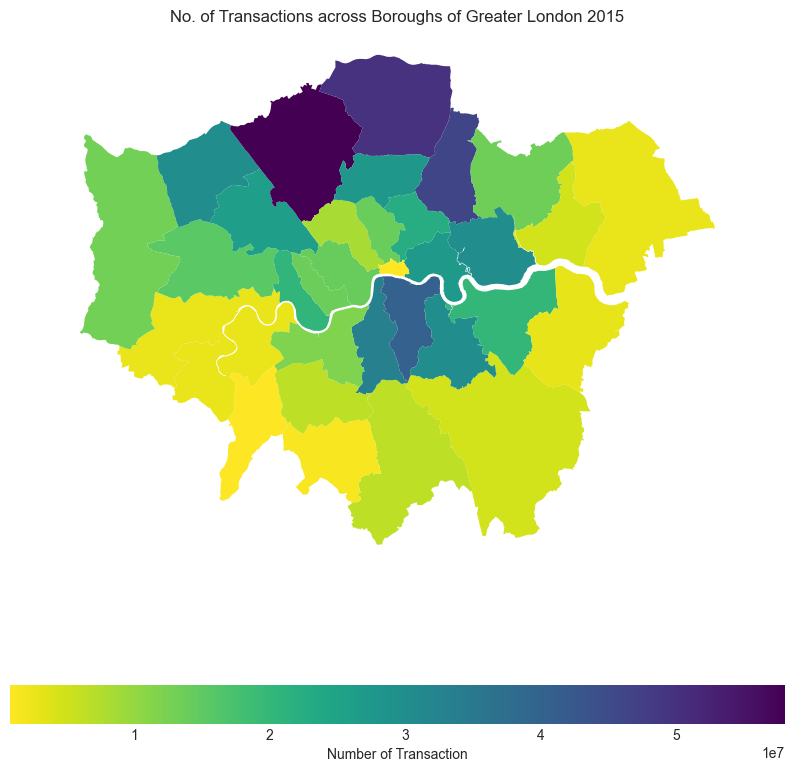

In [11]:
# Plotting map for transactions
gdf_borough = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp') # .shp file for borough, Reference[2]
new_df_1 = new_df.groupby('area_id').mean().reset_index()
gdf_merged = gdf_borough.merge(new_df_1, left_on='GSS_CODE', right_on='area_id', how='left')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.axis('off')
gdf_merged.plot(column='num_transactions', ax=ax, legend=True,cmap='viridis_r',legend_kwds={'label': "Number of Transaction",'orientation': "horizontal",})
plt.title('No. of Transactions across Boroughs of Greater London 2015')
plt.show()

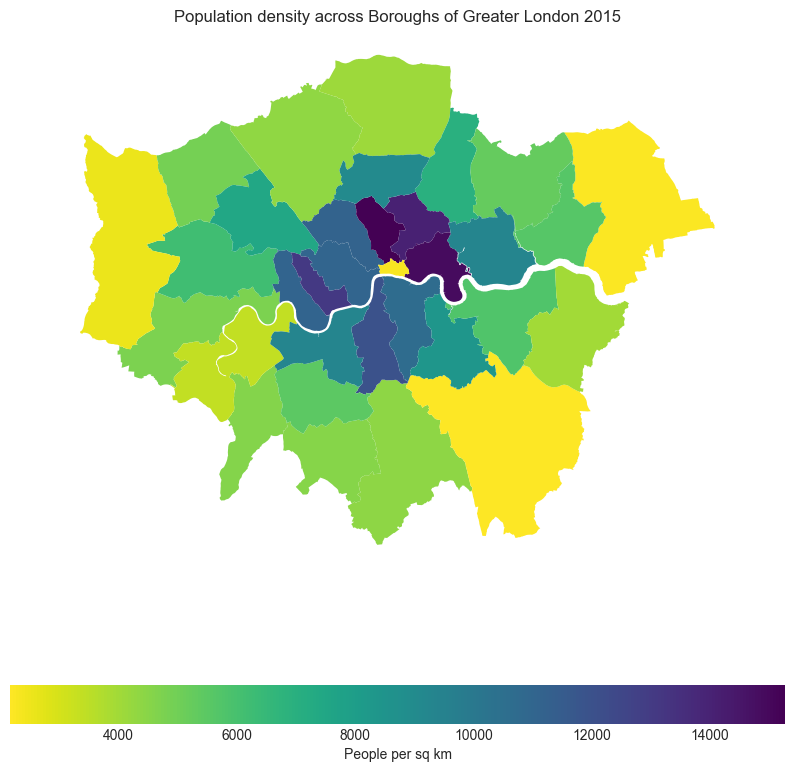

In [12]:
# Plotting map for Population density
new_df_1 = new_df.groupby('area_id').mean().reset_index()
gdf_merged = gdf_borough.merge(new_df_1, left_on='GSS_CODE', right_on='area_id', how='left')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.axis('off')
gdf_merged.plot(column='people_per_sq_km', ax=ax, legend=True,cmap='viridis_r',
                legend_kwds={'label': "People per sq km",
                             'orientation': "horizontal"})
plt.title('Population density across Boroughs of Greater London 2015')
plt.show()

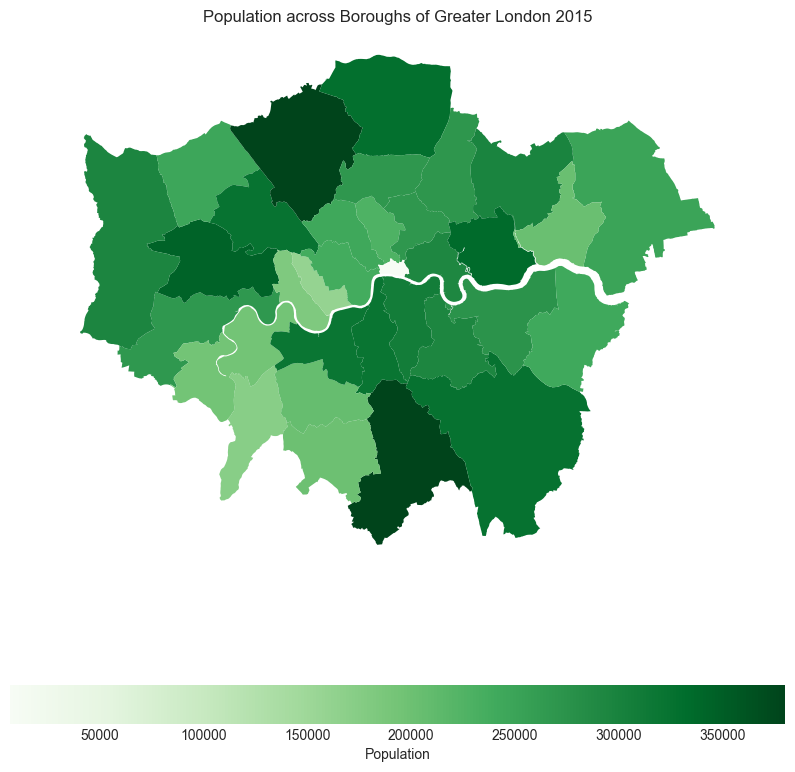

In [13]:
# Plotting map for Population
gdf_borough = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp') # .shp file for borough, Reference[2]
new_df_1 = new_df.groupby('area_id').mean().reset_index()
gdf_merged = gdf_borough.merge(new_df_1, left_on='GSS_CODE', right_on='area_id', how='left')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.axis('off')
gdf_merged.plot(column='population', ax=ax, legend=True,cmap='Greens',legend_kwds={'label': "Population",'orientation': "horizontal",})
plt.title('Population across Boroughs of Greater London 2015')
plt.show()

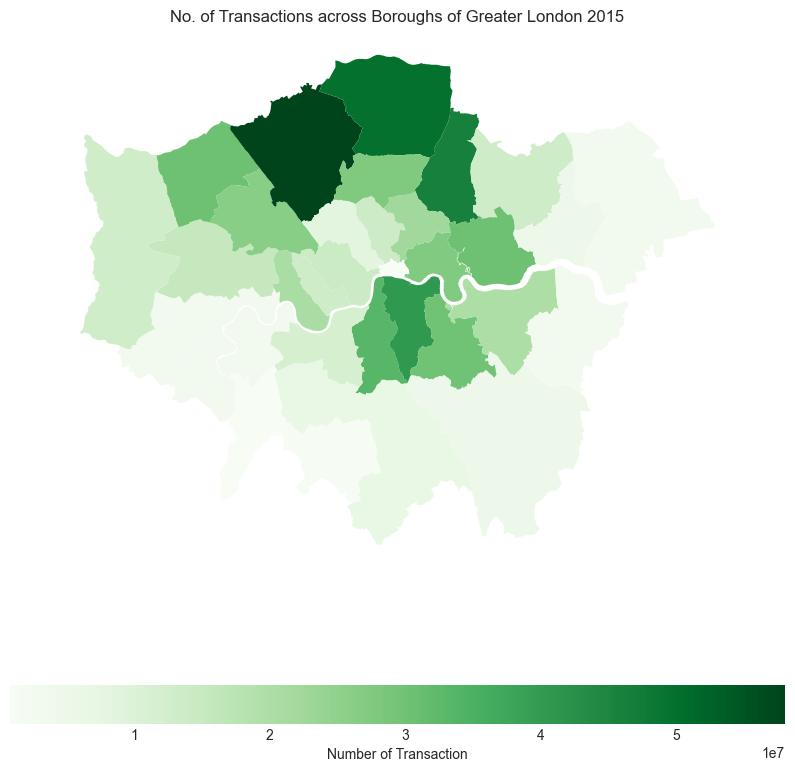

In [14]:
# Plotting map for transactions
gdf_borough = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp') # .shp file for borough, Reference[2]
new_df_1 = new_df.groupby('area_id').mean().reset_index()
gdf_merged = gdf_borough.merge(new_df_1, left_on='GSS_CODE', right_on='area_id', how='left')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.axis('off')
gdf_merged.plot(column='num_transactions', ax=ax, legend=True,cmap='Greens',legend_kwds={'label': "Number of Transaction",'orientation': "horizontal",})
plt.title('No. of Transactions across Boroughs of Greater London 2015')
plt.show()

In [15]:
# Checking correlation results
print(f'Population density vs transactions: {format(correlation, ".2f")}')
print(f'Population vs transactions: {format(correlation_1, ".2f")}')

Population density vs transactions: 0.27
Population vs transactions: 0.51


Task 3

Income dataset

In [16]:
df = pd.read_excel('earnings-workplace-borough.xls', sheet_name='FT workers annual Mean') # Reference [3]
df.replace('-', pd.NA, inplace=True)  
df.replace(',', '', regex=True, inplace=True) 
for col in df.columns[2:]: 
    df[col] = pd.to_numeric(df[col], errors='coerce') 

df.iloc[:, 2:] = df.iloc[:, 2:].interpolate(method='linear', axis=1, limit_direction='both')
for col in df.columns[2:]:
    df[col].fillna(df[col].mean(), inplace=True)
df=df.loc[1:33]
df.head()

,Code,Area,1999,2000,2001,2002,2003,2004,2005,2006,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
1,E09000001,City of London,48922.0,52203.0,62819.0,56450.0,64272.0,66628.0,74004.0,85886.0,...,83403.0,82808.0,77754.0,79489.0,80655.0,90028.0,88145.0,87817.0,93938.0,97149.0
2,E09000002,Barking and Dagenham,23620.0,24696.0,26050.0,26653.0,27792.0,29088.0,28728.0,28660.0,...,37214.0,36323.0,36705.0,37959.0,32093.0,32671.0,32086.0,35435.0,35632.0,32800.0
3,E09000003,Barnet,23128.0,25755.0,26068.0,30210.0,30518.0,30795.0,31652.0,30923.0,...,33766.0,34936.0,34730.0,35315.0,36818.0,36776.0,37319.0,38132.0,38136.0,39730.0
4,E09000004,Bexley,21386.0,22580.0,23559.0,23517.0,24723.0,24617.0,28162.0,28847.0,...,32463.0,31878.0,33367.0,32666.0,33857.0,34496.0,33993.0,36350.0,34710.0,39539.0
5,E09000005,Brent,20911.0,23726.0,24164.0,24071.0,29790.0,25416.0,27371.0,29712.0,...,34480.0,33484.0,34281.0,36579.0,35840.0,35830.0,36809.0,38287.0,36643.0,43241.0


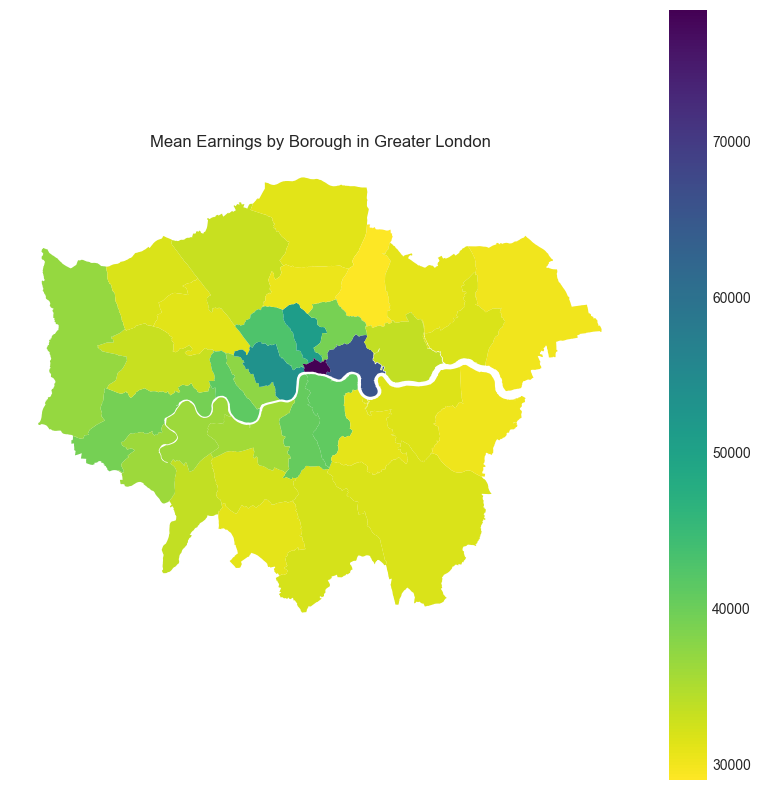

In [17]:
# Plotting map for mean earnings
df['mean_earnings'] = df.mean(axis=1)
gdf_borough = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp') # .shp file for borough, Reference[2]
gdf_merged = gdf_borough.merge(df, left_on='GSS_CODE', right_on='Code', how='left')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.axis('off')
gdf_merged.plot(column='mean_earnings', ax=ax, legend=True, cmap='viridis_r')
plt.title('Mean Earnings by Borough in Greater London')
plt.show()

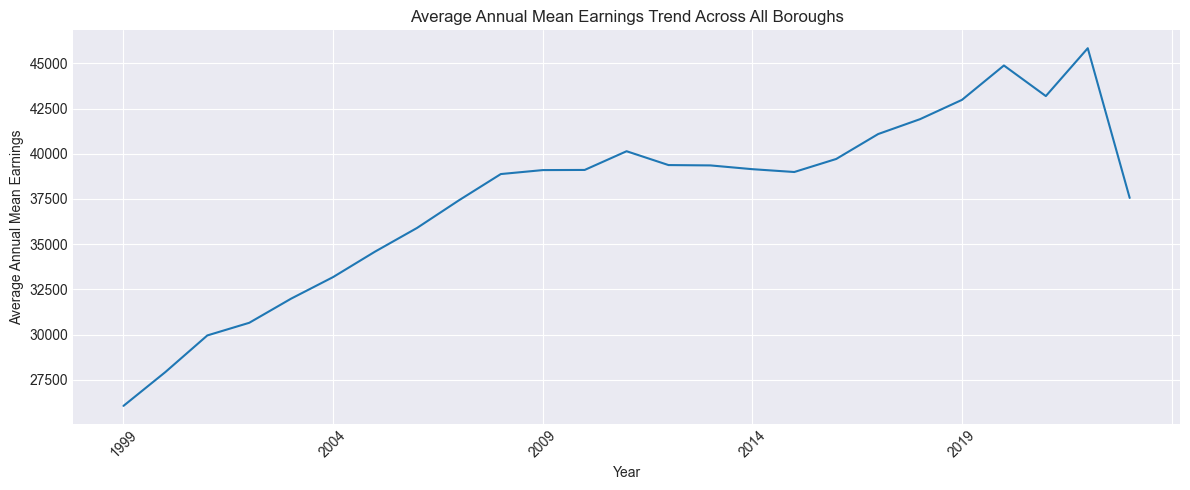

In [18]:
# Calculate and plotting average earnings per year across all boroughs
average_earnings_per_year = df.mean()
plt.figure(figsize=(12, 5))
average_earnings_per_year.plot(title='Average Annual Mean Earnings Trend Across All Boroughs')
plt.ylabel('Average Annual Mean Earnings')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Checking volatility using standard deviation of income across years

In [19]:
# Calculating volatility of income across boroughs
volatility = df.std(axis=1)
volatility=volatility.sort_values(ascending=False)
df=df.reset_index()
volatility_df = volatility.to_frame(name='value').reset_index()
final_volatility = pd.merge(df, volatility_df, on='index', how='inner')
final_volatility=final_volatility.sort_values(by='value', ascending=False)
final_volatility.head()

,index,Code,Area,1999,2000,2001,2002,2003,2004,2005,...,2015,2016,2017,2018,2019,2020,2021,2022,mean_earnings,value
0,1,E09000001,City of London,48922.0,52203.0,62819.0,56450.0,64272.0,66628.0,74004.0,...,77754.0,79489.0,80655.0,90028.0,88145.0,87817.0,93938.0,97149.0,78444.041667,12900.315582
29,30,E09000030,Tower Hamlets,37524.0,47253.0,55045.0,49998.0,55530.0,66095.0,71063.0,...,67320.0,64345.0,75103.0,69806.0,69264.0,69691.0,64803.0,74930.0,65577.000000,10241.593004
32,33,E09000033,Westminster,36167.0,40903.0,41566.0,43576.0,43694.0,46350.0,50430.0,...,53316.0,53888.0,59878.0,63792.0,60046.0,65105.0,61325.0,72402.0,53404.291667,8336.848603
27,28,E09000028,Southwark,26994.0,29101.0,29423.0,30906.0,32241.0,34875.0,36022.0,...,42316.0,42583.0,44008.0,48333.0,47876.0,53939.0,47785.0,53450.0,40969.500000,7406.039900
18,19,E09000019,Islington,34180.0,35135.0,44989.0,54080.0,49632.0,40812.0,37231.0,...,49576.0,52885.0,52752.0,53489.0,54154.0,56192.0,53443.0,55972.0,51094.875000,7267.964681


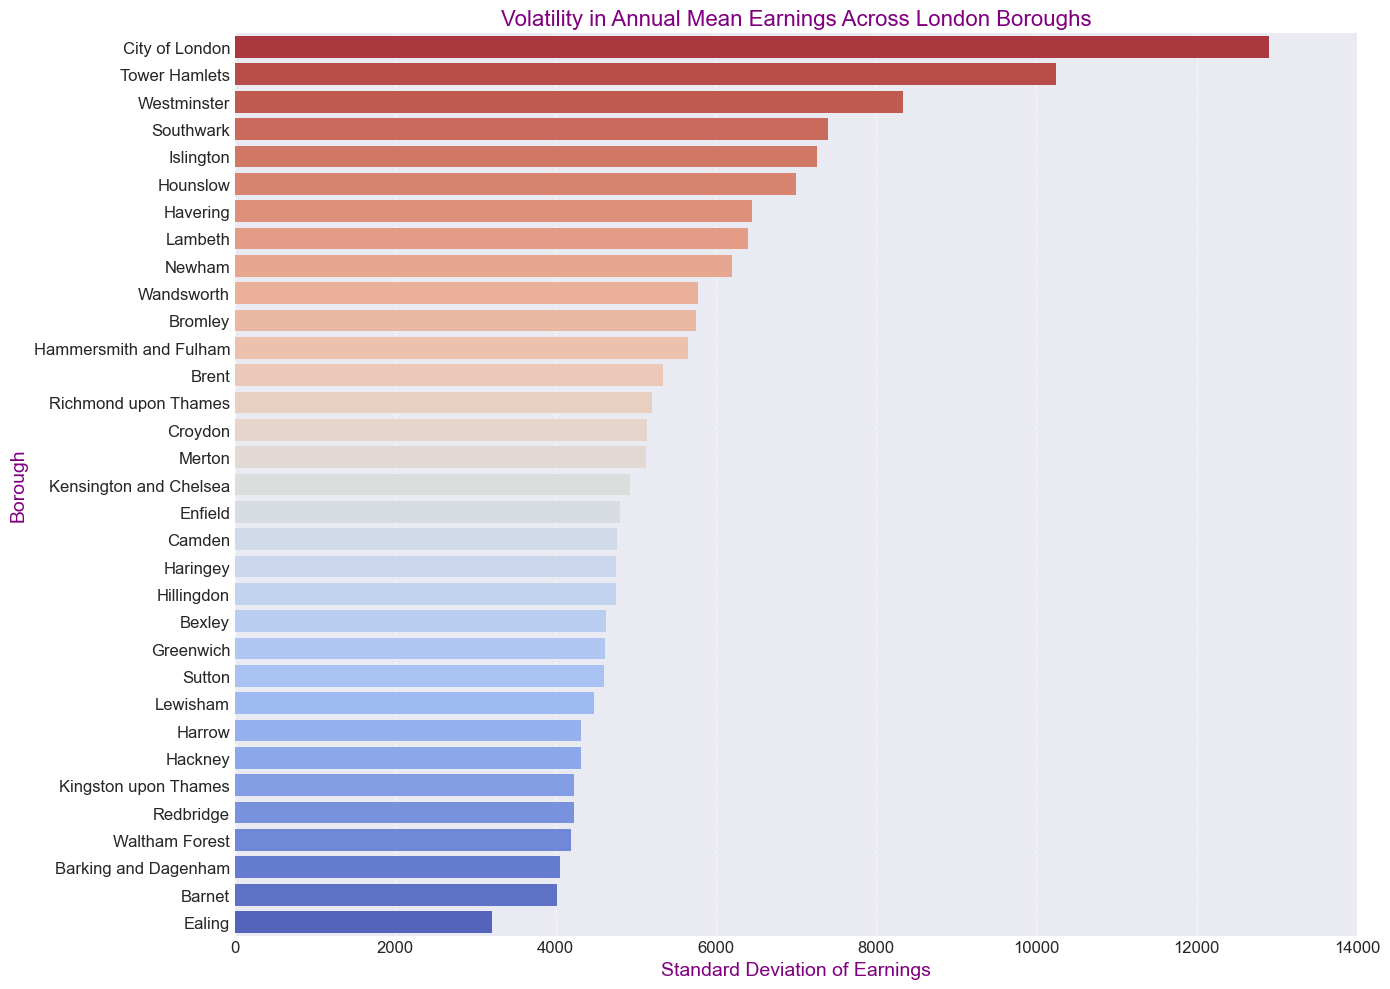

In [20]:
# plotting volatility of income across boroughs
plt.figure(figsize=(14, 10))
sns.barplot(x=final_volatility['value'], y=final_volatility['Area'], palette='coolwarm_r', orient='h')

plt.title('Volatility in Annual Mean Earnings Across London Boroughs', fontsize=16, color='Purple')
plt.ylabel('Borough', fontsize=14,color='Purple')
plt.xlabel('Standard Deviation of Earnings', fontsize=14,color='Purple')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0,14000)
plt.tight_layout()
plt.show()

Tesco dataset 1.0 vs Income

In [21]:
income_df=df[['Area',2015]]
income_df.reset_index(drop=True, inplace=True)
tesco_df=new_df
task3_df=pd.concat([tesco_df,income_df],axis=1)
task3_df=task3_df.rename(columns={2015:'Income'})

In [22]:
# Getting list of nutrients and food items for analysis
fields_food = ["f_dairy", "f_eggs", "f_fats_oils", "f_fish", "f_fruit_veg", 
    "f_grains", "f_meat_red", "f_poultry", "f_readymade", "f_sauces", 
    "f_soft_drinks","f_sweets", "f_tea_coffee"]
fields_nutrients=["fat", "saturate", "salt", 
    "sugar", "protein", "carb", "fibre","alcohol"]


For analysis, using spearman rank correlation for food, nutrient vs Income

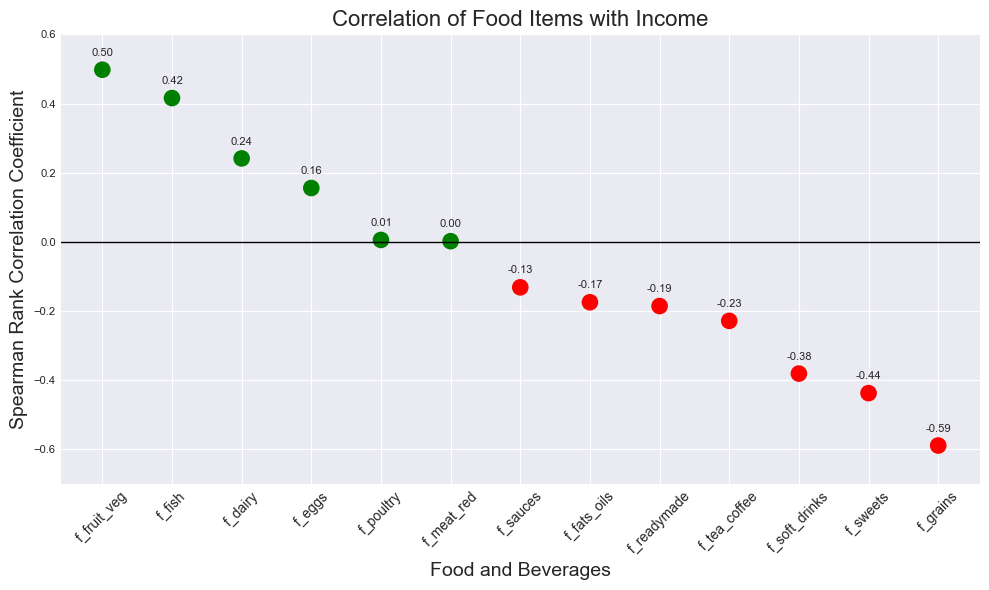

In [23]:
# Spearman rank correlation calculation and plotting the graph
spearman_corr_food =task3_df[fields_food].apply(lambda x: x.corr(task3_df['Income'], method='spearman'))
spearman_corr_food = spearman_corr_food.sort_values(ascending=False)

colors = ['green' if x > 0 else 'red' for x in spearman_corr_food]
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(spearman_corr_food.index, spearman_corr_food, s=120, c=colors)

for index, value in enumerate(spearman_corr_food):
    plt.annotate(f'{value:.2f}',(index, spearman_corr_food.iloc[index]),
                 textcoords="offset points",xytext=(0,10),ha='center', fontsize=8)

plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.title('Correlation of Food Items with Income', fontsize=16)
plt.xlabel('Food and Beverages', fontsize=14)
plt.ylabel('Spearman Rank Correlation Coefficient', fontsize=14)
plt.ylim(-0.7,0.6)
plt.axhline(0, color='black', lw=1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

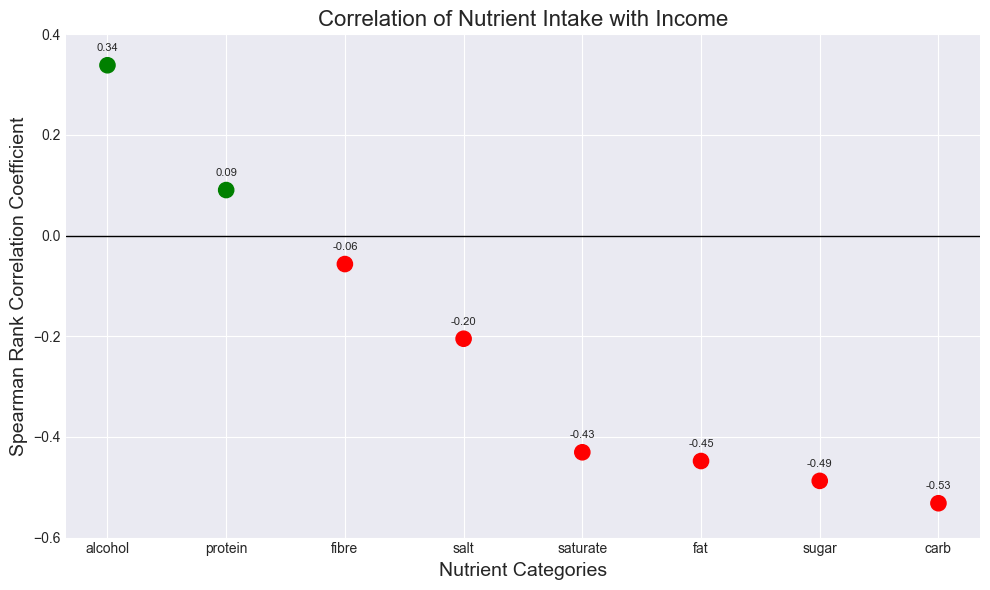

In [24]:
spearman_corr_nutrient =task3_df[fields_nutrients].apply(lambda x: x.corr(task3_df['Income'], method='spearman'))
spearman_corr_nutrient = spearman_corr_nutrient.sort_values(ascending=False)
colors = ['green' if x > 0 else 'red' for x in spearman_corr_nutrient]
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(spearman_corr_nutrient.index, spearman_corr_nutrient, s=120, c=colors)

for index, value in enumerate(spearman_corr_nutrient):
    plt.annotate(f'{value:.2f}',
                 (index, spearman_corr_nutrient.iloc[index]),
                 textcoords="offset points",
                 xytext=(0,10), 
                 ha='center',
                 fontsize=8)  

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Correlation of Nutrient Intake with Income', fontsize=16)
plt.xlabel('Nutrient Categories', fontsize=14)
plt.ylabel('Spearman Rank Correlation Coefficient', fontsize=14)
plt.ylim(-0.6,0.4)
plt.axhline(0, color='black', lw=1)
plt.tight_layout()
plt.show()

References

1. Aiello, L.M.,, Quercia, D.,, Schifanella, R., and Del Prete, L., 2020a. Tesco Grocery 1.0, a large-scale dataset of grocery purchases in London. Scientific Data, 7(1). <br>
2. Authority, G.L., 2014. Statistical gis boundary files for London. [online] London Datastore News. Available from: https://<wbr>data.london.gov.uk/dataset/statistical-gis-boundary-files-london [Accessed 10 Apr. 2024]. <br>
3. Authority, G.L., 2014. Earnings by workplace, borough. [online] London Datastore News. Available from: https://<wbr>data.london.gov.uk/dataset/earnings-workplace-borough [Accessed 10 Apr. 2024]. 
